In [ ]:
# data
import pandas as pd
import numpy as np
# visuals
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning, module='xgboost')

# Miami Home Sale Price Prediction Model

![Miami, Florida](https://media.istockphoto.com/photos/aerial-view-of-downtown-miami-florida-picture-id802893644?k=20&m=802893644&s=612x612&w=0&h=_nh3kgUZFP5EO8guUu91ZY-Y7RuxwAgzQwC187Wmb4A=)

The below 2021 housing data comes from Kaggle user Deep Contractor. It features `14,000` samples and `15` predictors.

## O. Gathering and examining source data
   - LINK TO DATA :  https://www.kaggle.com/deepcontractor/miami-housing-dataset

   - Attempted to remove outliers, but model performed worse with outliers removed. Further testing required to determine if this is due to overfitting or the model truly is more accurate if it considers more outliers. Options for further experimentation with model performance: implementing variations on cross validation, or trying a alternative tree-based models.

   - Additionally, later examining the permutation importances, will reveal to what degree the outliers are affecting the models' performance

In [ ]:
def get_quantiles(col):
    return col.quantile(.25), col.quantile(.75) - col.quantile(.25), col.quantile(.75)

In [ ]:
def wrangle(data_path):
    df = pd.read_csv(data_path)
    df.columns = df.columns.str.lower()
    df.drop('parcelno', axis=1, inplace=True)
    return df

url = 'https://raw.githubusercontent.com/sayerjk/miami-housing-2021/main/miami-housing.csv'
df = wrangle(url)
get_quantiles(df['sale_prc'])

### Outliers:

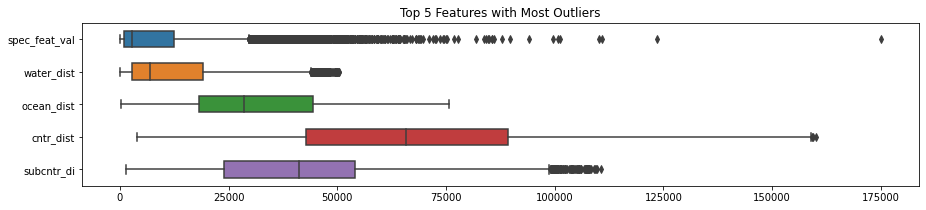

In [ ]:
features_to_tier = ['spec_feat_val', 'water_dist', 
                    'ocean_dist', 'cntr_dist', 'subcntr_di']
plt.figure(figsize= (15,3))
plt.title('Top 5 Features with Most Outliers')
sns.boxplot(data = df[features_to_tier], orient='h', width=.5);

In [ ]:
# 22% of the data had a special feature value that's an outlier (> 95th percentile)
spec_feat_val_outliers = df[df['spec_feat_val'] > 20000].shape[0] / len(df)

0.2156187194946885

## I. Split Data
- Almost `14,000` samples with `15` predictors to train models on
- Reserving `60%` of dataset for training models (appx. `8300` samples)
- The remaining `40%` of the data will be split evenly into validation and test sets to prevent data leakage and allow the model to generalize better (`appx. 2800` each)


In [ ]:
from sklearn.model_selection import train_test_split

#  CREATE feature matrix and target vector
target = 'sale_prc'
X = df.drop(target, axis=1)
y = df[target]

#  Training and validation split:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size= 0.4,
                                                  random_state= 42)

#  Validation and testing split: 
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size= 0.5,
                                                random_state= 42)

assert len(X_val) + len(X_test) + len(X_train) == len(df)

## II. Establish Baseline
- The average `sale price` over all subsets of the data is `$399k`. Based on the average, that is our best guess for the `sale price` of a single family home in the Miami area. 
- Examining the `mean absolute error`, we can see the average guess of `$399k` is extremely high, at almost `$200,000`. 
- But, having nothing but the `sale price`, our best guess is the `average`, because we have no other data. 
- The models below will train on `15` pieces of information per home sale, and give much more accurate predictions. 
- The middle `50% of single family homes` are selling in the `$235k - $428k` range, with a median of `$310k`

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_log_error
import statistics as stats

baseline_mean = [y.mean()] * len(df)
baseline_median = [stats.median(y)] * len(df)
baseline_mae = mean_absolute_error(y, baseline_mean)

print(f'Baseline median sale price: {baseline_median[0]}')
print(f'Mean sale price: {baseline_mean[0]}')
print(f'Baseline MAE (for mean baseline): {baseline_mae}')

Baseline median sale price: 310000.0
Mean sale price: 399941.9317398794
Baseline MAE (for mean baseline): 194570.47516453112


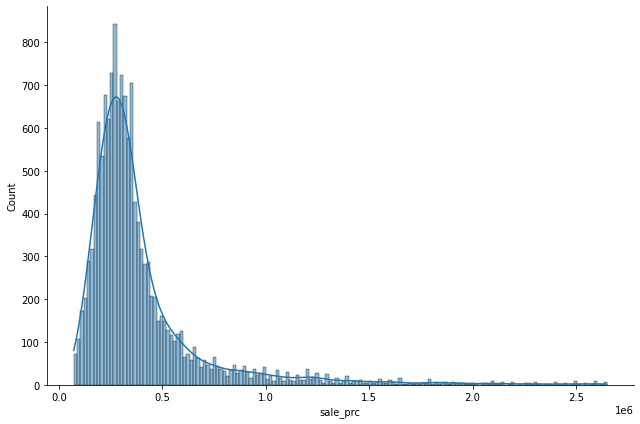

In [ ]:
# Baseline distribution of all Sale Prices
sns.displot(y, height=6, aspect=1.5, kde=True);

<Figure size 1080x216 with 0 Axes>

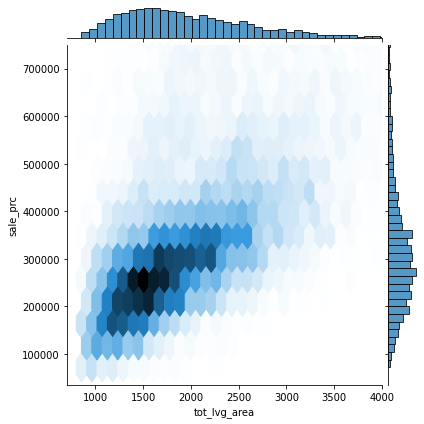

In [ ]:
plt.figure(figsize= (15,3))

sns.jointplot(
    x='tot_lvg_area', y='sale_prc', data=df,
    kind='hex', xlim=(700, 4000), ylim= (35000,.75e6), ratio=9
    );

### Plots on the map below contain `sale price` and `square footage`. Reformatting on the way. HTML can be incorperated into the bubbles associated with each point
    - Refresh the cell below to see 200 new samples

In [ ]:
import folium

In [ ]:
# map with for loop
# refresh for a new 200 sale listings
# TODO: write functions for converting sale price to dollars and lvg area to sqft
# TODO: could randomize map-center starting location

map_miami = folium.Map(location=[25.891324,-80.153968], zoom_start=12)

for (index,row) in df.sample(200).iterrows():
    folium.Marker(location=[row.loc['latitude'], row.loc['longitude']],
                  popup=str(row.loc['sale_prc']) + ' ' + str(row.loc['tot_lvg_area']), 
                  tooltip='click').add_to(map_miami)

map_miami

### Price and density can be seeing in the scatterplot below. Each point is 50% translucent, so stacked points appear darker on the map, indicating high density of sales in those areas. 

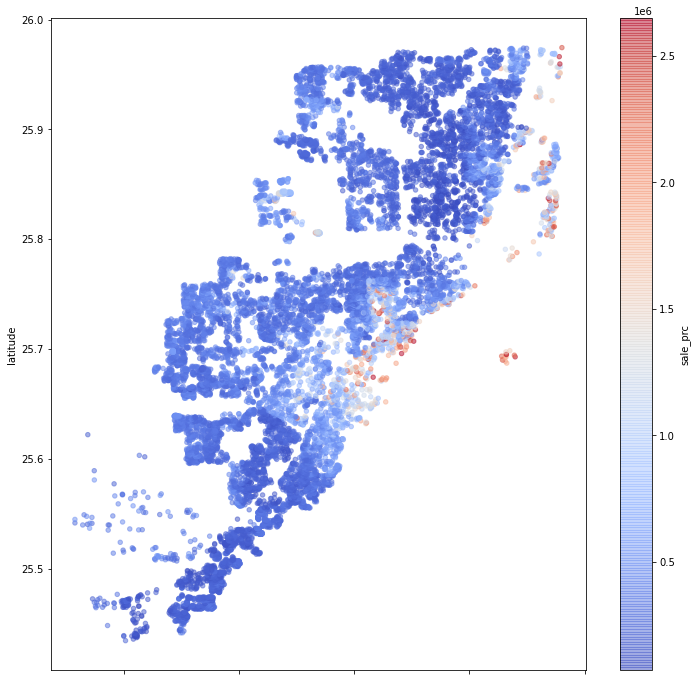

In [ ]:
df.plot(x="longitude", y="latitude",
        kind="scatter", c="sale_prc", 
        colormap="coolwarm", alpha=.5, figsize=(12,12))
plt.show()

## III. Build Model

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score
from sklearn.linear_model import Ridge, LinearRegression

### Linear Regression Model

In [ ]:
# Model fitting (default)
lr = LinearRegression()
lr.fit(X_train, y_train)

# Predictions from validation data
lr_preds = lr.predict(X_val)

# Coefficient table 
lr_coef_table = pd.DataFrame(data = lr.coef_, 
                             index= X_train.columns, 
                             columns= ['coefs']).sort_values(by='coefs', ascending=False)

#### Visualizations
- Here, with results from the linear regression model plotted against the true values of the validation data, we can see that the linear regression is picking up on a trend, but is very narrow in its scope, and not a very accurate reflection of the true sale prices. 
- From this visual, we can assume this model accounts for about 60% of the data, and is not even capable of producing values in the outer 40%. With the model only accoutning for 60% of the data (we can quantify this exactly later), it is only capable of 60% accuracy at best. 
- The coefficients of the regression line give us an idea of the most influential variable on our target, sale price, but due to this model's poor performance the coefficients here have a similar 60% accuracy
- The R^2 score of 0.69, which we will later see indicates the linear model accounts for only 69% of the varience in the training dataset, and unable to account for the remaining 31% (we guessed 40% earlier, based on the scatter plot)


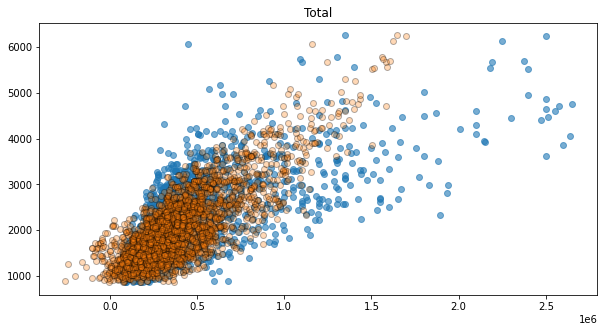

In [ ]:
''' VISUALIZATIONS '''
# display(lr_coef_table)

# Plotting results, x-label=sale_prc, y=tot_lvg_area

plt.figure(figsize=(10,5))
plt.title('Total')
plt.scatter(y_val, X_val['tot_lvg_area'], alpha=.6)
plt.scatter(lr_preds, X_val['tot_lvg_area'], alpha=.3, edgecolors='k')

results_df = X_val.copy()
results_df['y_val'], results_df['lr_preds'] = y_val, lr_preds

#### Ridge Regression Model

In [ ]:
# Fit RidgeRegression Model
rr = Ridge(alpha= 1.0)
rr.fit(X_train, y_train)

Ridge()

### Tree-Based Models

In [ ]:
from xgboost import XGBRegressor

dt = DecisionTreeRegressor(random_state=42)
dt.fit(X_train, y_train)

rf = RandomForestRegressor(random_state=42)
rf.fit(X_train, y_train)

xgb = XGBRegressor(random_state= 42, n_jobs= -1)
xgb.fit(X_train, y_train)

[00:48:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(n_jobs=-1, random_state=42)

### a. Tune Model with RandomizedSearchCV
 - Training and tuning and XGBoost Regression Model
 - Examined `n_estimators, max_depth, learning_rate, and min_child_weight parameters` in tuning process.
 - Expand for parameters, tuning, and results

I tuned all models and did not find better performance with hyperparameters other than their default. 

In [ ]:
# # Parameters for below search
# params = {
#     'n_estimators': [100, 400, 800],
#     'max_depth': [3, 6, 9],
#     'learning_rate': [0.05, 0.1, 0.20],
#     'min_child_weight': [1, 10, 100]
#     }

In [ ]:
# # ---- RANDOMIZED SEARCH CV() TEMPLATE ----
# from sklearn.model_selection import RandomizedSearchCV

# model_xgbrs = RandomizedSearchCV(
#     regressor,
#     random_state=42,
#     param_distributions = params,
#     n_jobs=-1,
#     cv=5, 
#     verbose=3,
#     n_iter = 10 
# )

# model_xgbrs.fit(X ,y)

# best_score = model_xgbrs.best_score_
# best_params = model_xgbrs.best_params_

# print('Best score for `model`:', best_score)
# print()
# print('Best params for `model`:', best_params)

# IV. Check Metrics

In [ ]:
# Model selection for visualizations below:
model = rf

In [ ]:
def check_metrics(model):
  '''
  Examines mean absolute error and r^2 scores
  for Training, Validation, and Test subsets
  '''  
  print(f'Training MAE: {mean_absolute_error(y_train, model.predict(X_train))}')
  print(f'Training R^2: {model.score(X_train, y_train)}')

  print(f'Validation MAE: {mean_absolute_error(y_val, model.predict(X_val))}')
  print(f'Validation R^2: {model.score(X_val, y_val)}')

  print(f'Test MAE: {mean_absolute_error(y_test, model.predict(X_test))}')
  print(f'Test R^2: {model.score(X_test, y_test)}')

  print()

# Model Selection (list of existing models for input to check_metrics): 
models = [lr, rr, dt, rf, xgb]

for m in models:
  print(m, '*default hyper/parameters')
  check_metrics(m)

LinearRegression() *default hyper/parameters
Training MAE: 112221.96849662493
Training R^2: 0.6979567292752087
Validation MAE: 116333.29341264402
Validation R^2: 0.6892745474915303
Test MAE: 114076.68866635226
Test R^2: 0.6964768963616821

Ridge() *default hyper/parameters
Training MAE: 111425.2201989908
Training R^2: 0.6961471289618207
Validation MAE: 115965.95625352947
Validation R^2: 0.6908268946200848
Test MAE: 113238.14727300794
Test R^2: 0.6956501110445303

DecisionTreeRegressor(random_state=42) *default hyper/parameters
Training MAE: 13.155481118156079
Training R^2: 0.9999981895758351
Validation MAE: 67359.80904522612
Validation R^2: 0.8061619323289735
Test MAE: 72563.02368137783
Test R^2: 0.7831105754997957

RandomForestRegressor(random_state=42) *default hyper/parameters
Training MAE: 17751.799724277793
Training R^2: 0.9863738226768991
Validation MAE: 46444.579117611866
Validation R^2: 0.9197969207171917
Test MAE: 50935.023504963516
Test R^2: 0.8920936337247601

XGBRegressor(n

The Random Forest Regressor performed best with an `R^2 Score of 0.892093` on the test data subset of the data. The new model has a **mean absolute error** of `$51,000`. Compared to the MAE of our baseline guess, `$200,000`, this model has the potenial to save millions per year and instill confidence in buyers, sellers, and investors as the quickly growing market of Miami. Note the `0.2%` and `$6,000` difference between the Random Forest Regressor and the XGB Regressor results.

I would like to return with more data, considering more factors, such as time and inflation, to make a model that would be more informative looking forward. Scaling the data will likely increase performance, since the model seems to be week on outliers, but strong in the bulk of the data.  

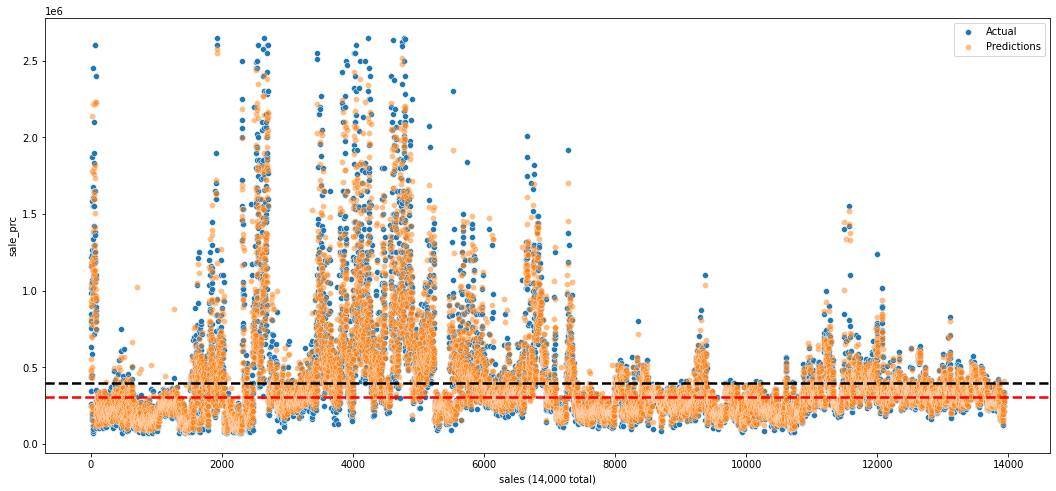

In [ ]:
plt.figure(figsize=(18,8))
sns.scatterplot(x=df.index, y='sale_prc', data=df, palette='colorblind')
sns.scatterplot(x=df.index, y= rf.predict(X), data=df, palette='colorblind', alpha=0.5)
plt.legend(labels=['Actual', 'Predictions', 'Baseline']);
# set line width here
plt.axhline(baseline_mean[0], lw=2.5, color='k', ls='--')
plt.axhline(baseline_median[0], lw=2.5, color='r', ls='--')
plt.xlabel('sales (14,000 total)');

Above we can see the mean and median based on the raw data, plotted against the true values (blue) and the Random Forest predictions (orange). And below is a histogram representation, with the IQR plotted out. 

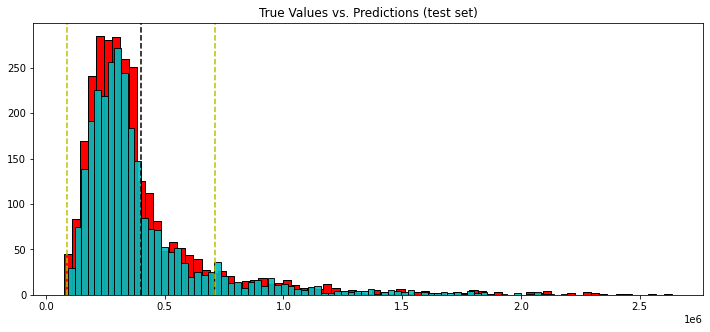

In [ ]:
import statistics

#  A look at predictions vs y_test and standard deviations for y_test
plt.figure(figsize=(12,5))
plt.title("True Values vs. Predictions (test set)")
plt.hist(y_test, bins=75, color='r', edgecolor='k')
plt.hist(model.predict(X_test), bins=75, color='c', edgecolor='k', alpha=0.9);

test_mean = statistics.mean(y_test)
pred_mean = statistics.mean(model.predict(X_test))
test_std = statistics.stdev(y_test)
pred_std = statistics.stdev(model.predict(X_test))

plt.axvline(test_mean, color='k', linestyle='dashed')
plt.axvline(test_mean + test_std, color='y', linestyle='dashed')
plt.axvline(test_mean - test_std, color='y', linestyle='dashed')


### a. Permutation Importance Metrics
In the model selection field below you can change the model whose metrics, permutation importances (feature significane/influece) to what each of the tree-based model's came up with. 

Although the linear models were far less acurate with their price predictions, they still point out relevant features. The XGBoost model's permutation importances have overlap in their rankings, but in practicality, the permutation importances of XGBoost are much more accurate measures of a properties worth, and hold stronger predictive power. 

In [ ]:
from sklearn.inspection import permutation_importance

pimp = permutation_importance(model, X_val, y_val, random_state= 42)

In [ ]:
pimp_data = {'imp_mean' : pimp['importances_mean'],
             'imp_std' : pimp['importances_std']}

permutation_importance_df = pd.DataFrame(pimp_data, index= X_val.columns).sort_values(by= 'imp_mean', ascending=False)
permutation_importance_df

,imp_mean,imp_std
tot_lvg_area,0.485518,0.012426
ocean_dist,0.189595,0.004501
longitude,0.073776,0.011519
structure_quality,0.062974,0.004395
cntr_dist,0.058344,0.005799
subcntr_di,0.055682,0.004537
water_dist,0.045567,0.002334
age,0.032114,0.007047
lnd_sqfoot,0.018420,0.001199
rail_dist,0.016336,0.001902


In [ ]:
# Linear regression coefficeints 
# lr_coef_table

### b. Partial Dependence Plots for single variables

In [ ]:
'''
PIP INSTALL PDPBOX AND SHAP HERE
'''
!pip install pdpbox shap

In [ ]:
from pdpbox.pdp import pdp_isolate, pdp_plot, pdp_interact, pdp_interact_plot
import shap

In [ ]:
feature = 'ocean_dist'

In [ ]:
isolate = pdp_isolate(
    model,
    dataset= X_val,
    model_features= X_val.columns,
    feature= feature
)

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


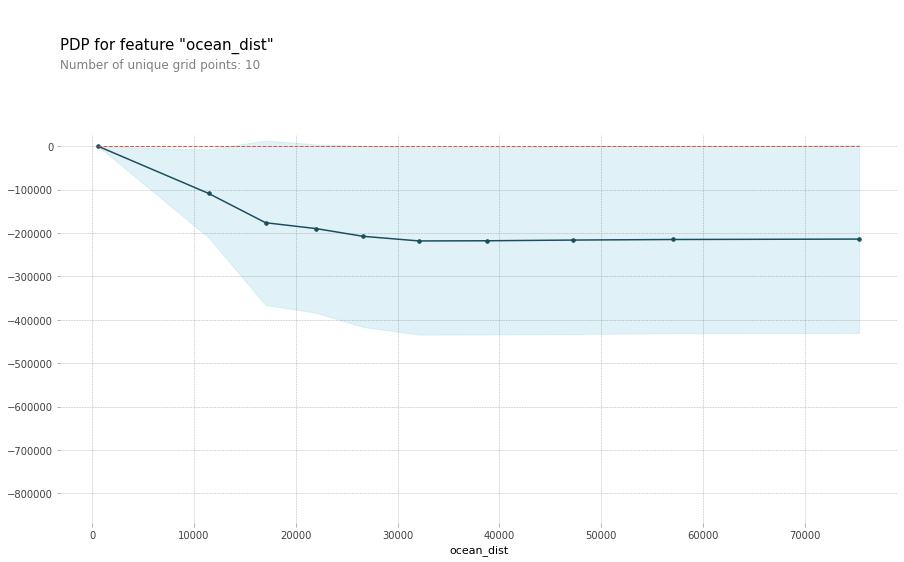

In [ ]:
pdp_plot(isolate, feature_name=feature);

In [ ]:
isolate.pdp

array([574268.21860373, 465717.99987078, 398122.4504062 , 384556.7749001 ,
       366708.30216858, 356060.59384123, 356476.3641894 , 358088.72771058,
       359399.71551747, 360367.61430426])

In [ ]:
# features = ['tot_lvg_area', 'ocean_dist']

In [ ]:
# interact = pdp_interact(
#     model,
#     dataset= X_val,
#     model_features= X_val.columns,
#     features= features
# )

In [ ]:
# pdp_interact_plot(interact, plot_type='grid', feature_names= features);

### c. Shapley force plots for an individual predictions
Shaply plot illustrates exactly the degree each individual factor in our dataset affected the prediction given by the model. The red values are driving the price higher, and the blue drive it lower. The permutation importances' ranked living area size and ocean distance as the top driving price factors for single family homes. The significance of these two variables is reflected in for every sample the force plots displayed below.  


In [ ]:
# # Same model variable from earlier, added this comment incase you 
# # want to reassign and reasses other models here, instead of scrolling

# model = model

explainer = shap.TreeExplainer(model)

In [ ]:
sample_row = X_val.sample(1)

shap_values = explainer.shap_values(sample_row)

shap.initjs()
shap.force_plot(
    base_value = explainer.expected_value,
    shap_values = shap_values,
    features= sample_row
)

## END OF NOTEBOOK
---